# **Import Libraries and Load Dataset**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score

file_path = "/content/drive/MyDrive/Projects/CAR DETAILS FROM CAR DEKHO.csv"
data = pd.read_csv(file_path)
print(data.head())


                       name  year  selling_price  km_driven    fuel  \
0             Maruti 800 AC  2007          60000      70000  Petrol   
1  Maruti Wagon R LXI Minor  2007         135000      50000  Petrol   
2      Hyundai Verna 1.6 SX  2012         600000     100000  Diesel   
3    Datsun RediGO T Option  2017         250000      46000  Petrol   
4     Honda Amaze VX i-DTEC  2014         450000     141000  Diesel   

  seller_type transmission         owner  
0  Individual       Manual   First Owner  
1  Individual       Manual   First Owner  
2  Individual       Manual   First Owner  
3  Individual       Manual   First Owner  
4  Individual       Manual  Second Owner  


# **Check for Missing Values**

In [7]:
print("Missing values in each column:\n", data.isnull().sum())
print(data.info())
print(data.describe())


Missing values in each column:
 name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB
None
              year  selling_price      km_driven
count  4340.000000   4.340000e+03    4340.000000
mean   2013.090783   5.041273e+05   66215.777419
std       4.215344   5.785487e+05   46644.102194
min    1992.00

# **Visualize Data**

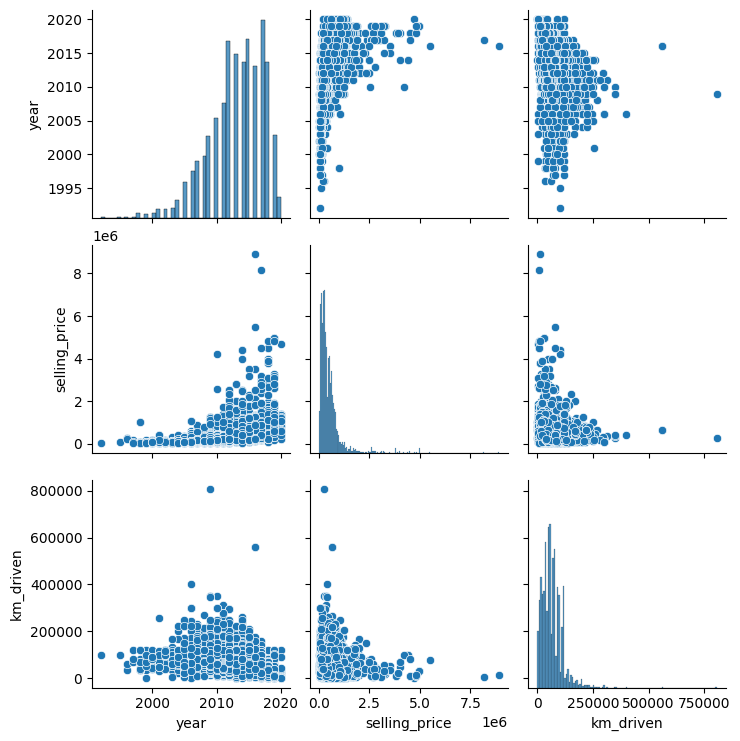

In [8]:
sns.pairplot(data)
plt.show()


**Encode Categorical Features and Create New Feature**

In [9]:
le = LabelEncoder()
data['fuel'] = le.fit_transform(data['fuel'])
data['seller_type'] = le.fit_transform(data['seller_type'])
data['transmission'] = le.fit_transform(data['transmission'])
data['owner'] = le.fit_transform(data['owner'])


data['car_age'] = 2024 - data['year']


**Handle Missing Values**

In [10]:
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())


# **Handle Outliers**

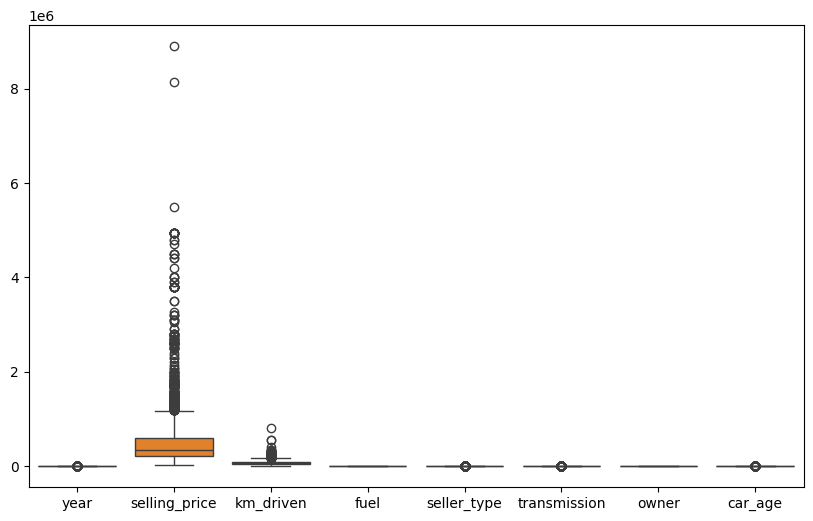

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[numeric_cols])
plt.show()

Q1 = data[numeric_cols].quantile(0.25)
Q3 = data[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
data = data[~((data[numeric_cols] < (Q1 - 1.5 * IQR)) | (data[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]


**Scale Numeric Features**

In [12]:
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])


**Split Data into Training and Testing Sets**

In [13]:
X = data[['km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'car_age']]
y = data['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# **Train XGBoost Model with Hyperparameter Tuning**

In [14]:

xgb_model = XGBRegressor(random_state=42)

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

random_search_xgb = RandomizedSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='neg_mean_absolute_error', n_iter=50, random_state=42, n_jobs=-1)
random_search_xgb.fit(X_train, y_train)

print(f'Best parameters for XGBoost: {random_search_xgb.best_params_}')


Best parameters for XGBoost: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


**Evaluate the Best Model**

In [15]:
best_xgb_model = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)

print(f'XGBoost MAE: {mean_absolute_error(y_test, y_pred_xgb)}')
print(f'XGBoost RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb))}')


XGBoost MAE: 0.4723202554466904
XGBoost RMSE: 0.6468593286954452


**Cross-Validation for XGBoost**

XGBoost Cross-Validation MAE: 0.47602782264049387


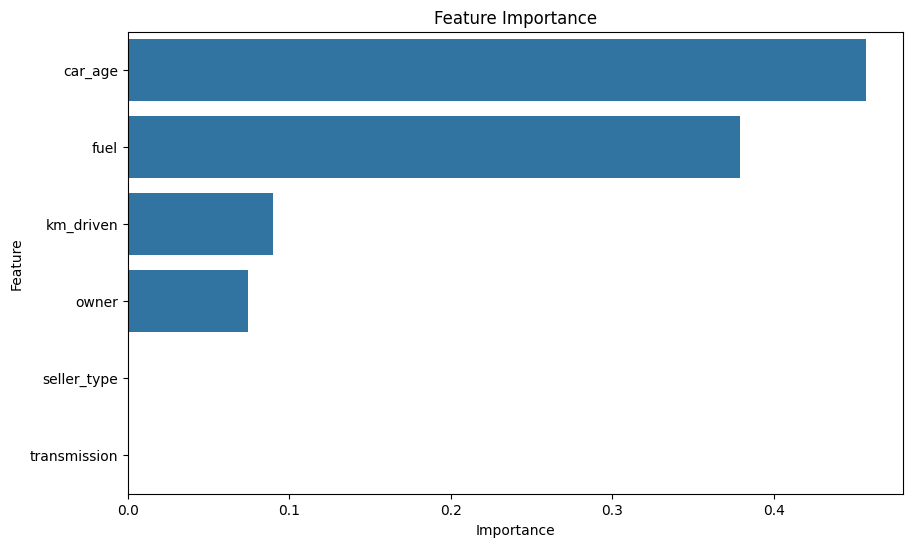

In [16]:
cv_scores = cross_val_score(best_xgb_model, X, y, scoring='neg_mean_absolute_error', cv=5)
print(f'XGBoost Cross-Validation MAE: {-cv_scores.mean()}')

importances = best_xgb_model.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()
